In [6]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 40

In [7]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

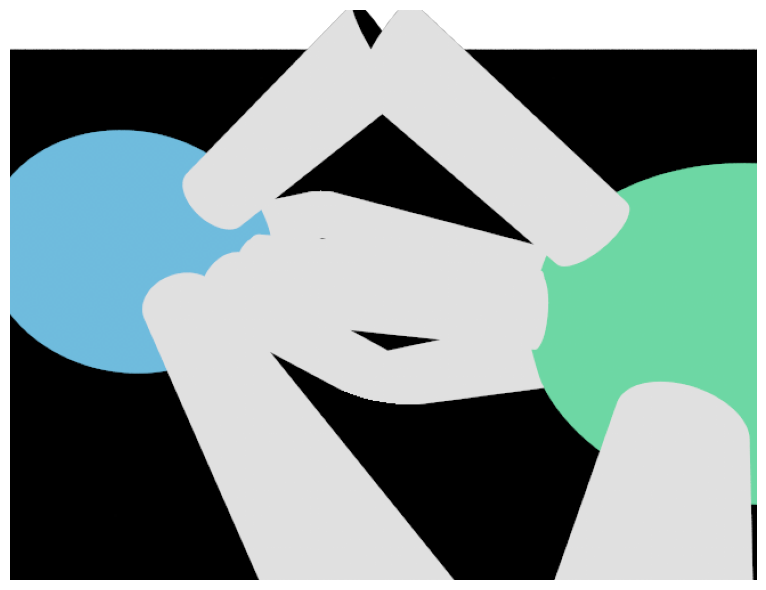

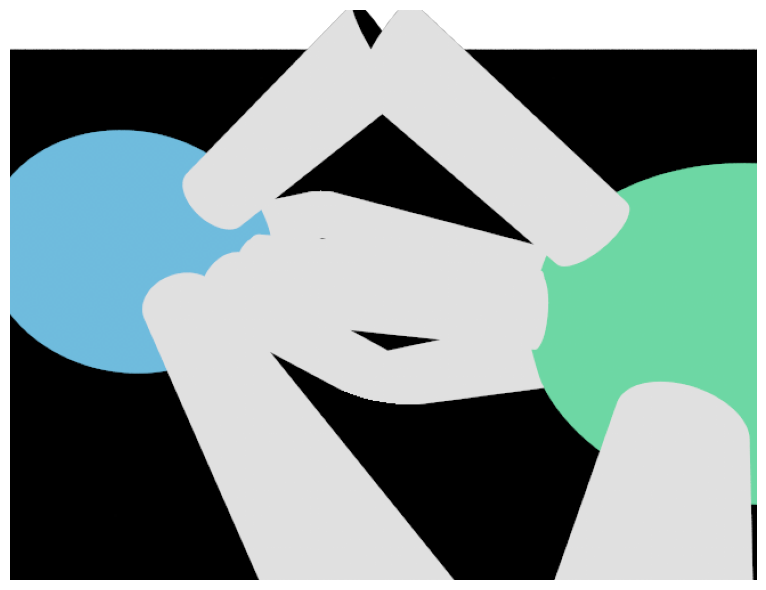

In [8]:
scene = load_scene("../models/simple_room/simple_room.xml")
scene.frequency = 2.14e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
# Place a transmitter
tx0 = Transmitter("tx0", position=[5.0, 1, 1.0], look_at=[0,0,0])
scene.add(tx0)
# tx1 = Transmitter("tx1", position=[5.0, 3, 1.0], look_at=[0,0,0])
# scene.add(tx1)

rx = Receiver("rx", position=[1.0, 2.0, 1.0], look_at=[0,0,0])
scene.add(rx)

ris = RIS("ris", position=[1.0, 2.0, 1.0], look_at=[0,0,0], num_cols=3, num_rows=3)

# camera = Camera("camera", position=[0.5, 2.0, 2.5], look_at=[5.0, 2, 1.0])
camera = Camera("camera", position=[3, 3.9, 2.5], look_at=[3, 2, 1.25])
scene.add(camera)
paths = scene.compute_paths(max_depth=1,
                            num_samples=1e2)

scene.render(camera="camera", num_samples=128, fov=90,
             paths=paths, show_paths=True)

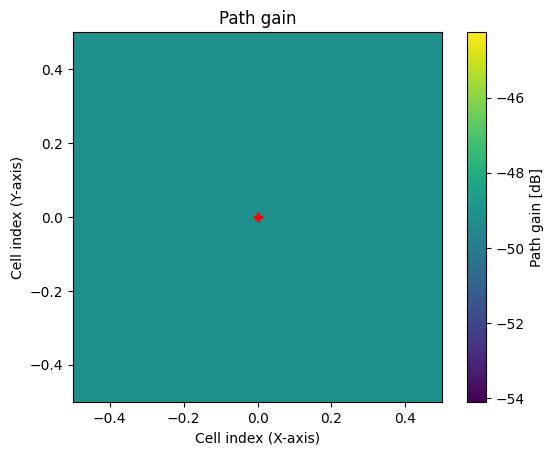

In [9]:
cover_map = scene.coverage_map(max_depth=2,
                        diffraction=True, # Disable to see the effects of diffraction
                        combining_vec=None,
                        precoding_vec=None,
                        num_samples=int(20e2)) # Reduce if your hardware does not have enough memory
p = cover_map.show()